# Income and Consumption Inequality

## Overview

In this notebook I will use the `QuantEcon` libraries [inequality](https://quanteconpy.readthedocs.io/en/latest/tools/inequality.html) tools to plot  lorenze curves and find their gini coefficients using income and consumption data from Italy, Australia, US, ...

I will use `pandas` to manage and clean the data.

I will discuss how income inequality has changed over the years and the differences across countries. 

I will need the following imports

In [1]:
import pandas as pd
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import quantecon as qe
from numba import njit, prange

## Refresh

I will be using the lorenz curve and gini coefficent to measure the income inequality in these countries. 


The Lorenz curve plots percentiles of the population on the horizontal axis and cumulative income on the vertical axis. 

The Gini coefficient measures the inequality among values of a frequency distribution. A gini coefficient of 0 indicates perfect equality, and of 1 indicates complete inequality. 


Here is a quick refesh from [Wealth Dynamics](https://python.quantecon.org/wealth_dynamics.html) of how we can use the `QuantEcon` inequality library to plot Lorenz curves and find gini coefficients. 


In [2]:
n = 10_000                      # size of sample
w = np.exp(np.random.randn(n))  # lognormal draws

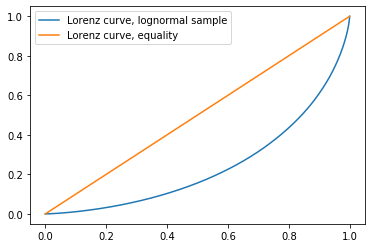

In [3]:
f_vals, l_vals = qe.lorenz_curve(w)

fig, ax = plt.subplots()
ax.plot(f_vals, l_vals, label='Lorenz curve, lognormal sample')
ax.plot(f_vals, f_vals, label='Lorenz curve, equality')
ax.legend()
plt.show()

In [4]:
qe.gini_coefficient(w)

0.5228737847901275

## Data

I will be using data from all three countries. 

The Italian data comes from the [bank of italy](https://www.bancaditalia.it/statistiche/tematiche/indagini-famiglie-imprese/bilanci-famiglie/distribuzione-microdati/index.html). I will be using there historical data base and we will step you through how to clean and handle their data.

The US data comes from the Survey of Consumer Finances [(SCF)](https://www.federalreserve.gov/econres/aboutscf.htm). The SCF is a cross-sectional survey of U.S. families. The survey data includes information on family balance sheets, pensions, income, and demographic characteristics. I have colladed it historical data from 1989 us until the most recent available survey in 2016. This data is trick as it has a oversampling of rich households. To over come this the SFC provides weights to be representative of the US. 


Unfortunatley the Australian data is confidential and so we will not be able to share the code we use to generate it's curves.


## Income

### Italy

First we will import the data into a `pandas` dataframe.

In [5]:
italy_path = r'italian_data/rfam.dta'
italy_data = pd.read_stata(italy_path)

In [6]:
# Display 6 columns for viewing purposes
pd.set_option('display.max_columns', 10)
italy_data.head()

,nquest,anno,yl,yl1,yl2,...,y,ycf1l,ycf2l,ycf3l,ycfl
0,1,1977,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
1,2,1977,774.685364,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,3,1977,4157.478027,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
3,4,1977,4131.655273,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
4,5,1977,2024.510986,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


The varible we are interested in is Net disposable income which is `y`. You can find documentation for this on page 7 [here](https://www.bancaditalia.it/statistiche/tematiche/indagini-famiglie-imprese/bilanci-famiglie/documentazione/Shiw-Historical-Database.pdf?language_id=1).

In [7]:
italy_income = italy_data[['anno','y']]

In [8]:
italy_income.head()

,anno,y
0,1977,NaN
1,1977,NaN
2,1977,NaN
3,1977,NaN
4,1977,NaN


To help ourselves out we will rename the columns to year and income.

In [9]:
italy_income = italy_income.rename(columns={"anno": "year", "y": "income"})
italy_income.head()

,year,income
0,1977,NaN
1,1977,NaN
2,1977,NaN
3,1977,NaN
4,1977,NaN


We can see this data from starts from the year 1977. However the survey did not report Net disposable income until 1987. Thus we will only look at data from 1987 onwards.

In [10]:
italy_income = italy_income[italy_income['year'] >= 1987]

In [11]:
italy_income.head()

,year,income
36184,1987,26520.869141
36185,1987,7599.146973
36186,1987,12669.238281
36187,1987,5681.025879
36188,1987,33535.875000


Now we have the data we want lets plot the lorenz curve for the first year and the last year of the data set. 

In [12]:
italy_87 = np.array(italy_income[italy_income['year']==1987]['income'])
italy_87.sort()
italy_16 = np.array(italy_income[italy_income['year']==2016]['income'])
italy_16.sort()

x_87, y_87 = qe.lorenz_curve(italy_87)
x_16, y_16 = qe.lorenz_curve(italy_16)

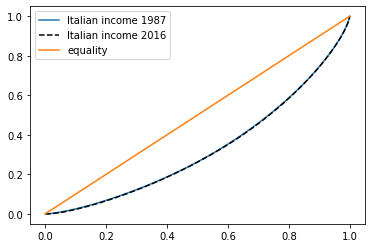

In [13]:
fig, ax = plt.subplots()
ax.plot(x_87, y_87, label='Italian income 1987')
ax.plot(x_16, y_16,'k--', label='Italian income 2016')
ax.plot(x_87, x_87, label='equality')
ax.legend()
plt.show()

It doesn't look like there has been to much of a change from 1987 to 2016. Lets look at the rank size plot.

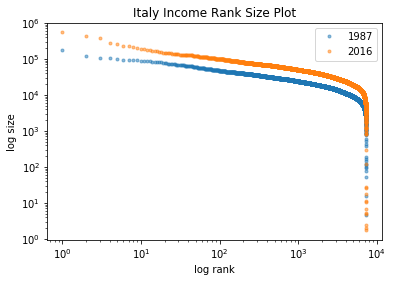

In [14]:
fig, ax = plt.subplots()
ax.set_title('Italy Income Rank Size Plot')
qe.rank_size_plot(italy_87,ax, label='1987')
qe.rank_size_plot(italy_16,ax, label='2016')

Let see if there has been much of a change in the gini coefficient over the years. 

In [15]:
years_italy = np.array(italy_income['year'].drop_duplicates())
years_italy

array([1987, 1989, 1991, 1993, 1995, 1998, 2000, 2002, 2004, 2006, 2008,
       2010, 2012, 2014, 2016], dtype=int16)

In [16]:
gini_italy =[]
for year in years_italy:
    year_income = np.array(italy_income[italy_income['year']==year]['income'])
    gini_italy.append(qe.gini_coefficient(year_income))

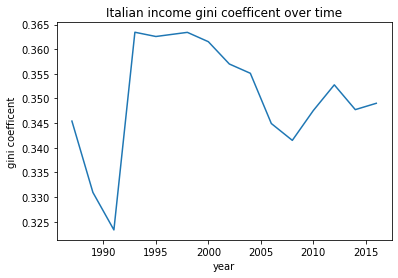

In [17]:
plt.figure()
plt.plot(years_italy,gini_italy)
plt.title('Italian income gini coefficent over time')
plt.xlabel('year')
plt.ylabel('gini coefficent')

plt.show()

## US

The data set I provide you for the US has already been cleaned and only has the desired data needed to produce our figures. 

In [18]:
us_path = r'us_data/scf_incomes.csv'
us_income = pd.read_csv(us_path)
us_income.head()

,year,income,weight
0,1989,5000,34299.798639
1,1989,5000,36092.019025
2,1989,5000,34911.938054
3,1989,5000,35289.974830
4,1989,5000,34673.534160


The SFC has an oversampling of high income households and thus needs to be re-weighted. Thankfully the SFC provides us with these weights.

In [19]:
us_income['w-income'] = us_income['income']*us_income['weight']
us_income.head()

,year,income,weight,w-income
0,1989,5000,34299.798639,1.714990e+08
1,1989,5000,36092.019025,1.804601e+08
2,1989,5000,34911.938054,1.745597e+08
3,1989,5000,35289.974830,1.764499e+08
4,1989,5000,34673.534160,1.733677e+08


Above is total income for a household. 

In [20]:
us_89 = np.array(us_income[us_income['year'] == 1989]['w-income'])
us_89.sort()
us_16 = np.array(us_income[us_income['year'] == 2016]['w-income'])
us_16.sort()

In [21]:
usx_89, usy_89 = qe.lorenz_curve(us_89)
usx_16, usy_16 = qe.lorenz_curve(us_16)

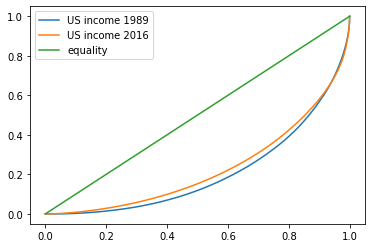

In [22]:
fig, ax = plt.subplots()
ax.plot(usx_89, usy_89, label='US income 1989')
ax.plot(usx_16, usy_16, label='US income 2016')
ax.plot(usx_16, usx_16, label='equality')
ax.legend()
plt.show()

This is interesting because it seems that inequality has declined in the US since 1989. 

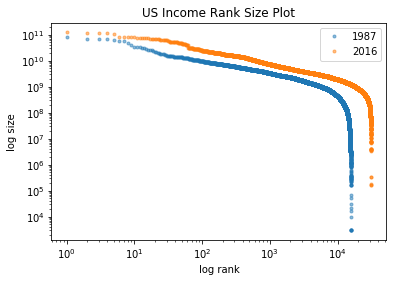

In [23]:
fig, ax = plt.subplots()
ax.set_title('US Income Rank Size Plot')
qe.rank_size_plot(us_89,ax, label='1987')
qe.rank_size_plot(us_16,ax, label='2016')

In [28]:
years_us = np.array(us_income['year'].drop_duplicates())
years_us

array([1989, 1992, 1995, 1998, 2001, 2004, 2007, 2010, 2013, 2016])

In [29]:
gini_income_us =[]
for year in years_us:
    income = np.array(us_income[us_income['year']==year]['w-income'])
    gini_income_us.append(qe.gini_coefficient(income))

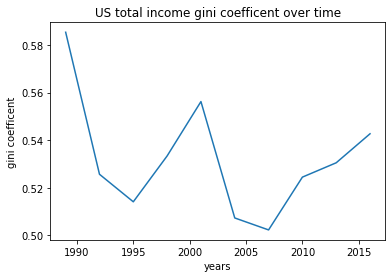

In [30]:
plt.plot(years_us, gini_income_us )
plt.title('US total income gini coefficent over time')
plt.xlabel('years')
plt.ylabel('gini coefficent')

plt.show()

This is questionable. This might be because I'm using total income as the varibale... Not happy with this I'm exploring other data sources. 

### US Data 

I will be using data from a [paper](https://www.aeaweb.org/articles?id=10.1257/aer.20120599) by Mark Aguiar and Mark Bils published in the AER. They colate data from the [Consumer Expenditure Surveys](https://www.bls.gov/cex/pumd.htm) conduced by the U.S. Bureau of Labor Statistics. It easier to use there as I can not find a file holding the historical data of this survey over time. 

In [31]:
path4 = r'us_data/annual2_nd.dta'
annual = pd.read_stata(path4)
annual.head()

,FINLWT21,BLS_URBN,SEX_REF,AGE2,SEX2,...,nweight,A_INCLASS,inclass,NT_INCLASS,ts_INCLASS
0,22300.160,1,1,57.0,2,...,1.385510,3.0,3.0,3,NaN
1,27044.098,1,1,NaN,,...,1.680251,1.0,2.0,2,1.0
2,42163.669,1,1,39.0,2,...,2.619630,3.0,3.0,3,3.0
3,42163.669,1,2,NaN,,...,2.619630,NaN,NaN,1,NaN
4,31818.949,1,1,24.0,2,...,1.976912,2.0,2.0,2,2.0


In [32]:
annual = annual[['year','TS_FINCATAR']] #TS_FINCATAR is Total amount of family income after taxes in the last 12 months
annual.head()

,year,TS_FINCATAR
0,1980,NaN
1,1980,10661.932403
2,1980,22495.228934
3,1980,3564.263964
4,1980,14883.472819


In [33]:
annual= annual.dropna()
annual.head()

,year,TS_FINCATAR
1,1980,10661.932403
2,1980,22495.228934
3,1980,3564.263964
4,1980,14883.472819
5,1980,9240.761112


In [34]:
ce_years = np.array(annual['year'].drop_duplicates())

In [35]:
gini_income_us_ce =[]
for year in ce_years:
    year_income = annual[annual['year']==year]['TS_FINCATAR']
    income_ce = np.array(year_income)
    
    gini_income_us_ce.append(qe.gini_coefficient(income_ce))

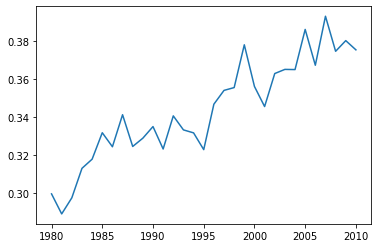

In [36]:
plt.figure()


plt.plot(ce_years, gini_income_us_ce)
plt.show()

## Australia

While we can't show you how we handled this data set as we have with the previous two, we can discuss the figure it generates

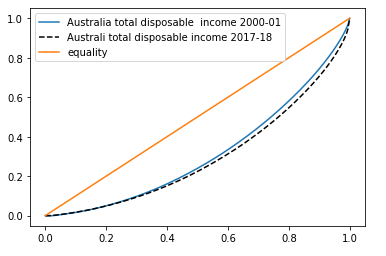

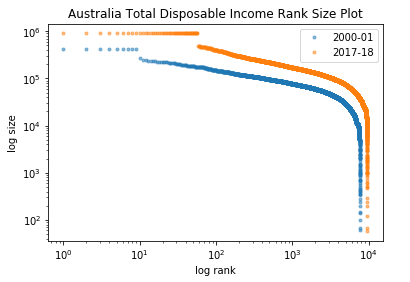

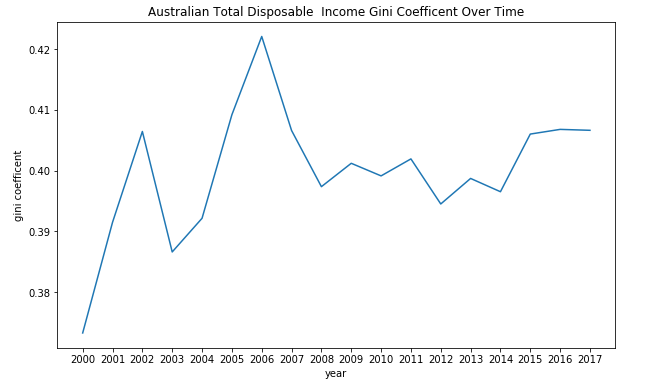

## Comparing across countries

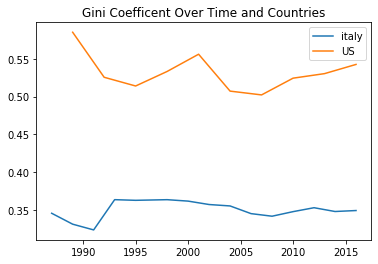

In [42]:
fig, ax = plt.subplots()

ax.plot(years_italy,gini_italy, label='italy')
ax.plot(years_us,gini_income_us, label='US')
ax.set_title('Gini Coefficent Over Time and Countries')
ax.legend()
plt.show()

Here is the same graph but with Australia added.
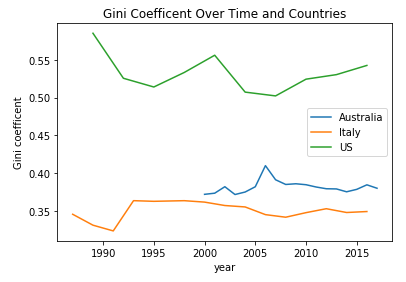

## Consumption

### Italy

In [33]:
path4 = r'~/Documents/projects/lorenz_curve/italian_data/cons.dta'
italy_cons = pd.read_stata(path4)
italy_cons.head()

,nquest,anno,y1,c,cd1,...,cd,cn,s1,s,y
0,1,1977,1586.555542,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
1,2,1977,1305.086548,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,3,1977,4157.478027,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
3,4,1977,4131.655273,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
4,5,1977,4251.989746,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


They only started collecting consumption data `c` from 1980. So we will remove all data from years prior to 1980.

In [34]:
italy_cons = italy_cons[['anno','c']]
italy_cons = italy_cons.rename(columns={"anno": "year", "c": "cons"}) #rename varibales
italy_cons = italy_cons[italy_cons['year'] >= 1980]
italy_cons.head()

,year,cons
8845,1980,1518.383301
8846,1980,2542.000977
8847,1980,1859.244873
8848,1980,9606.098633
8849,1980,2478.993164


In [35]:
italy_cons_80 = np.array(italy_cons[italy_cons['year']==1980]['cons'])
italy_cons_80.sort()
italy_cons_16 = np.array(italy_cons[italy_cons['year']==2016]['cons'])
italy_cons_16.sort()

x_80, y_80 = qe.lorenz_curve(italy_cons_80)
x_16, y_16 = qe.lorenz_curve(italy_cons_16)

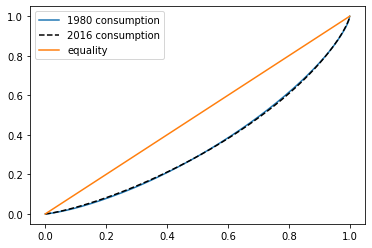

In [36]:
plt.figure()
plt.plot(x_80, y_80, label='1980 consumption')
plt.plot(x_16, y_16, 'k--',label='2016 consumption')
plt.plot(x_16, x_16, label='equality')
plt.legend()
plt.show()

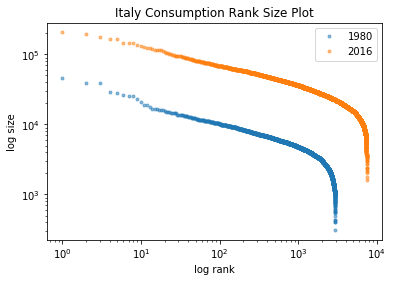

In [37]:
fig, ax = plt.subplots()
ax.set_title('Italy Consumption Rank Size Plot')
qe.rank_size_plot(italy_cons_80,ax, label='1980')
qe.rank_size_plot(italy_cons_16,ax, label='2016')

In [38]:
years_cons_it = np.array(italy_cons['year'].drop_duplicates())
years_cons_it

array([1980, 1981, 1982, 1983, 1984, 1986, 1987, 1989, 1991, 1993, 1995,
       1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016],
      dtype=int16)

In [39]:
gini_cons_italy =[]
for year in years_cons_it:
    consumption = np.array(italy_cons[italy_cons['year']==year]['cons'])
    gini_cons_italy.append(qe.gini_coefficient(consumption))

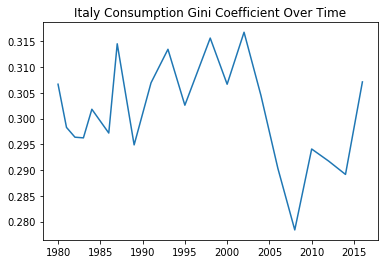

In [40]:
plt.figure()
plt.plot(years_cons_it, gini_cons_italy)
plt.title('Italy Consumption Gini Coefficient Over Time')
plt.show()

### US